In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd 
import math 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

# Functions

In [2]:
def load_excel(data_set, sheet_name):
    df = pd.read_excel("data-sets/%s.xlsx"%data_set,
                  true_values='Yes',
                  false_values='No',
                  sheet_name=sheet_name)
    df = df.fillna('')  
    df = df.replace('\n','')
    df = df.replace('-','')
    #df['Species'] = df['Species'].replace('sp.','')
    #df['Species'] = df['Species'].replace('spp.','')
    return df

def bar_orders(df):
    counts = df['Order'].value_counts()
    labels = list(counts.index[:5])
    labels.append('Other')
    counts = counts.reset_index(drop=True)
    counts[5] = sum(counts[5:])
    counts = counts.drop(range(6,len(counts)))
    new_df = pd.DataFrame({'counts':np.array(counts)},index=labels)
    return new_df.values.flatten(), new_df.index

def bar_roles(df):
    counts = df['Role'].value_counts()
    labels = list(counts.index[:3])
    labels.append('Other')
    counts = counts.reset_index(drop=True)
    counts[3] = sum(counts[3:])
    counts = counts.drop(range(4,len(counts)))
    new_df = pd.DataFrame({'counts':np.array(counts)},index=labels)
    return new_df.values.flatten(), new_df.index

def plot_barcharts(df, train_test='train'):
    fig, axs = plt.subplots(1,2,figsize=(8, 3),constrained_layout=True)
    x, y = bar_orders(df)
    #axs[0].grid(axis='y')
    axs[0].bar(y,x)
    axs[0].set_title('Orders')
    #fig.suptitle(['Validation', 'Test'][i],y=1.05)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xticks(np.arange(len(y)))
    axs[0].set_xticklabels(y, rotation=20, ha='right')
    
    x, y = bar_roles(df)
    #axs[1].grid(axis='y')
    axs[1].bar(y,x)
    axs[1].set_title('Roles')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xticks(np.arange(len(y)))
    axs[1].set_xticklabels(y, rotation=20, ha='right')
    
    if train_test=='train':
        #fig.suptitle('Validation Set',fontsize=14)
        plt.savefig('figures/barcharts_train.png', dpi=500)
    if train_test=='test':
        #fig.suptitle('Test Set',fontsize=14)
        plt.savefig('figures/barcharts_test.png', dpi=500)
    plt.show()
    return

def match_substrings(substrings, main_strings):
    if len(substrings) != len(main_strings):
        raise ValueError("Both lists should be of the same length")
    result = []
    for sub, main in zip(substrings, main_strings):
        # Check for exact match first
        if sub == main:
            result.append(True)
        else:
            # Then check if substring is a word in main string
            if sub == "":
                result.append(main == "")
            elif main == "":
                result.append(False)
            else:
                result.append(sub in main.split())
    return result

def print_taxonomic_mistakes(df1_, df2_):
    total = 0
    print('Mismatches:\n')
    for T in ['Class','Order','Family','Genus','Species']:
        not_in = np.array([not x for x in match_substrings(df1_[T], df2_[T])])
        print(T+' |', not_in.sum())
        total += not_in.sum()
        print("{0:10} | {1:25} | {2:20} | {3:30} | {4:30}".format("Index","Manual label","Prediction","Species (manual)","Species (prediction)"))
        print('-'*100)
        for i in range(not_in.sum()):
            T_true = np.array(df1_[T][not_in])[i]
            T_pred = np.array(df2_[T][not_in])[i]
            if T_pred == '':
                T_pred = '      '
            print("{0:10} | {1:25} | {2:20} | {3:30} | {4:30}".format(np.array(df1_[T][not_in].index)[i],T_true, T_pred, 
                                                   ' '.join([np.array(df1_['Genus'][not_in])[i],
                                                   np.array(df1_['Species'][not_in])[i]]),
                                                   ' '.join([np.array(df2_['Genus'][not_in])[i],
                                                   np.array(df2_['Species'][not_in])[i]])))
        print('\n')
    print('Total mismatches:')
    print(total)
    print('\nAccuracy:')
    all = len(df1_)*5
    print(all-total,'/',all,'=',np.round((all-total)/all,3))
    return total

def corrected_mistakes(TI):
    a_sum = 0
    b_sum = 0
    c_sum = 0
    d_sum = 0
    e_sum = 0
    f_sum = 0
    g_sum = 0
    h_sum = 0
    print("{0:15} | {1:15} | {2:15} | {3:15} | {4:15} | {5:20} | {6:20}".format('tot. mismatch', 'minor', 'major', 'minor mistake', 'mistake', 'mismatch GPT correct','mismatch ML wrong'))
    for i,(a,b,c,d,e,f) in enumerate([
                    [TI.m_c, TI.mmm_c, TI.mm_c, TI.mis_c, TI.mc_c, TI.mg_c],               # class
                    [TI.m_o, TI.mmm_o, TI.mm_o, TI.mis_o, TI.mc_o, TI.mg_o],               # order 
                    [TI.m_f, TI.mmm_f, TI.mm_f, TI.mis_f, TI.mc_f, TI.mg_f],               # family 
                    [TI.m_g, TI.mmm_g, TI.mm_g, TI.mis_g, TI.mc_g, TI.mg_g],               # genus 
                    [TI.m_s, TI.mmm_s, TI.mm_s, TI.mis_s, TI.mc_s, TI.mg_s],               # species
                   ]):
        a_ = len(a) # total mismatches
        b_ = len(b) # minor mismatches
        c_ = len(a)-len(b) # major mismatches
        d_ = len(c) # minor mistake
        e_ = len(d) # actual mistakes
        f_ = len(e) # mismatches where GPT-4 was actually correct
        g_ = len(f) # mismatches where manual label was actually wrong
        if i<3: 
            h_ = len(set(d).intersection(set([TI.i_c, TI.i_o, TI.i_f][i]))) # of actual mistakes, how many inferred?
            h_sum += h_
            
        a_sum += a_
        b_sum += b_
        c_sum += c_
        d_sum += d_
        e_sum += e_
        f_sum += f_ 
        g_sum += g_
        print("{0:15} | {1:15} | {2:15} | {3:15} | {4:15} | {5:20} | {6:20}".format(a_, b_, c_, d_, e_, f_, g_))
    print('-'*130)
    print("{0:15} | {1:15} | {2:15} | {3:15} | {4:15} | {5:20} | {6:20}".format(a_sum,b_sum,c_sum,d_sum,e_sum,f_sum, g_sum))
    return a_sum, b_sum, c_sum, d_sum, e_sum, f_sum, g_sum, h_sum

def species_found(df1,df2):
    u1 = np.unique(df1['EID'])
    u2 = np.unique(df2['EID'])
    print('         EID    \t|     Species Found  \t|')
    print('-'*50)
    u_list = []
    for u in u1: 
        n1 = len(df1[df1['EID']==u].index)
        n2 = len(df2[df2['EID']==u].index)
        if n1!=n2: 
            print(u,'\t| \t', n2,'/',n1,'  \t|  X')
            u_list.append(u)
        else:
            print(u,'\t| \t', n2,'/',n1,'  \t|')
    print('\nTotal:\n')
    print(len(df1)-len(df2[df2['EID']==''].index),'/',len(df1),'=',
          np.round((len(df1)-len(df2[df2['EID']==''].index))/len(df1),3))
    return

def plot_confusion_matrix(a1,a2,labels,xlab='GPT-4 Prediction',ylab='Manual Label',figsize=(9,6),xrot=45,yrot=0,train_test='train',filename=''):
    
    cm = confusion_matrix(a1,a2, labels=labels)

    # calculate row sums (for calculating % & plot annotations)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    # calculate proportions
    cm_perc = cm / cm_sum.astype(float) * 100
    cm_perc[np.isnan(cm_perc)] = 0.0
    # empty array for holding annotations for each cell in the heatmap
    annot = np.empty_like(cm).astype(str)
    # get the dimensions
    nrows, ncols = cm.shape
    # cycle over cells and create annotations for each cell
    for i in range(nrows):
        for j in range(ncols):
            # get the count for the cell
            c = cm[i, j]
            # get the percentage for the cell
            p = cm_perc[i, j]
            if np.isnan(p):
                p = 0.
            if i == j:
                s = cm_sum[i]
                # convert the proportion, count, and row sum to a string with pretty formatting
                annot[i, j] = '%.1f%%\n%d' % (p, c)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    # convert the array to a dataframe. To plot by proportion instead of number, use cm_perc in the DataFrame instead of cm
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'True'
    cm.columns.name = 'Pred'

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap=plt.cm.Blues, linewidths=2., cbar=False, vmin=0, vmax=100)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel(xlab, labelpad=10)
    ax.set_ylabel(ylab, labelpad=10)
    plt.xticks(rotation=xrot)
    plt.yticks(rotation=yrot)
    
    # Add colorbar
    cbar = ax.figure.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.015)
    cbar.outline.set_visible(False)
    cbar.set_label('Percentage correct', rotation=90, labelpad=10)
    

    plt.tight_layout()

    if train_test=='train':
        #plt.title("Validation Set")
        plt.savefig('figures/confusion_matrices/%s_train.png'%filename,dpi=500)
    if train_test=='test':
        #plt.title("Test Set")
        plt.savefig('figures/confusion_matrices/%s_test.png'%filename,dpi=500)
    plt.show()
    print('\n')
    report = classification_report(a1, a2,labels=labels, zero_division=0., digits=3)
    print(report)
    return

def print_accuracy_and_mismatches(indices, df1, df2):
    print('Accuracy and mismatches:')
    for inf, lab in zip(indices,['Class','Order','Family']):
        arr1 = df1.loc[inf][df2.loc[inf]['EID']!=''][lab]
        arr2 = df2.loc[inf][df2.loc[inf]['EID']!=''][lab]
        l = len(arr1) #(arr1!='Insecta').sum() # commented selection for insects only
        a = (arr1==arr2).sum() #((arr1==arr2) & (arr1!='Insecta')).sum() # commented selection for insects only
        print('\n%s:'%lab,a,'/',l,'=',np.round(a/l,3))
        indx = arr1[(arr1!=arr2)].index
        print("Index\t{:15s}\t{:15s}".format('Manual','Predicted'))
        print("----------------------------------")
        for _, (i,j) in enumerate(zip(arr1.loc[indx], arr2.loc[indx])):
            print(indx[_],"\t{:15s}\t{:15s}".format(i,j))
    return 
    
def scores_per_abstract(arr1, arr2, eids, header='', labels=[]): 

    for i, lab in enumerate(labels):
        dic = {}
        lengths = []
        support = []
        for eid in eids:
            a1 = arr1[arr1['EID']==eid][header].astype(str)
            a2 = arr2[arr2['EID']==eid][header].astype(str)
            if (a1==lab).sum()>0: 
                support.append(eid)
            report = classification_report(a1==lab, a2==lab, output_dict=True, zero_division=np.nan)
            if 'True' in report.keys():
                dic[eid] = report['True']  
                lengths.append(len(a1))
        
        vals_precision = np.array([value['precision'] for value in dic.values() if not np.isnan(value['precision'])])
        vals_recall = np.array([value['recall'] for value in dic.values() if not np.isnan(value['recall'])])
        vals_f1 = np.array([value['f1-score'] for value in dic.values() if not np.isnan(value['f1-score'])])
    
        lengths = np.array(lengths)
        
        print('Label:', lab,'(num abstracts: %s)'%len(support))
        print('precision:\t{:.1f} +/- {:.1f}'.format(100*np.mean(vals_precision), 100*np.std(vals_precision)))
        print('recall:\t\t{:.1f} +/- {:.1f}'.format(100*np.mean(vals_recall), 100*np.std(vals_recall)))
        print('f1:\t\t{:.1f} +/- {:.1f}'.format(100*np.mean(vals_f1), 100*np.std(vals_f1)))
        print('\n')
    return 

# Data

## Loading training and test dataframes

In [3]:
df1_train = load_excel('training_set', sheet_name=0)
df2_train = load_excel('training_set', sheet_name=1)

df1_test = load_excel('test_set', sheet_name=0)
df2_test = load_excel('test_set', sheet_name=1)

/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


## Dataframes overview

In [4]:
df1_train.head()

,Class,Order,Family,Genus,Species,Role,Generalist/Specialist,Pest Controller,Pest Names,Pest Type,Associated With,Affects,Description,Location,Category,EID,Additional note
0,Insecta,Hymenoptera,Agaonidae,Pleistodontes,imperialis,Pollinator,,,,,,,"Pollinator. Pleistodontes imperialis, the wasp...",Northern New Zealand,3,2-s2.0-0000101789,
1,Insecta,Hymenoptera,Agaonidae,Pleistodontes,froggatti,Pollinator,,,,,,,Polllinator wasp specific to F. macrophylla,Northern New Zealand,3,2-s2.0-0000101789,
2,Insecta,Coleoptera,Carabidae,Abax,parallelepipedus,Predator,,1.0,arionid slugs,Invertebrate,Agriculture,,Predator feeding on arionid slugs in field crops,,1a,2-s2.0-0000252648,
3,Gastropoda,Stylommatophora,Arionidae,Arion,ater,Pest,,,,Invertebrate,Agriculture,,"arionid slug, pest",,3,2-s2.0-0000252648,
4,Gastropoda,Stylommatophora,Arionidae,Arion,hortensis,Pest,,,,Invertebrate,Agriculture,,"arionid slug, pest",,3,2-s2.0-0000252648,


In [5]:
print('Training set:')
print('Total abstracts: ',len(np.unique(df1_train['EID'])))
print('Total species:   ', len(df1_train))

print('\nTest set:')
print('Total abstracts: ',len(np.unique(df1_test['EID'])))
print('Total species:   ', len(df1_test))

Training set:
Total abstracts:  100
Total species:    649

Test set:
Total abstracts:  100
Total species:    245


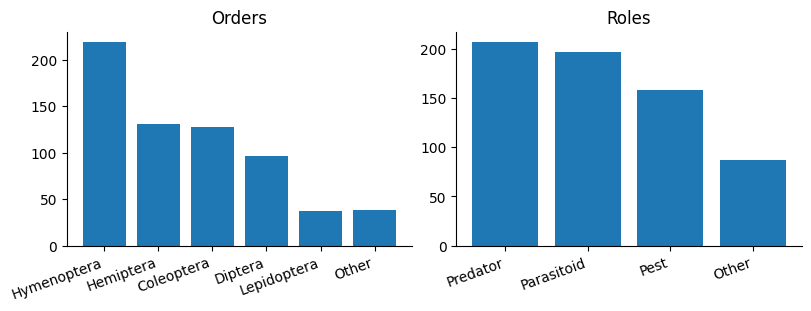

In [6]:
plot_barcharts(df1_train, train_test='train')

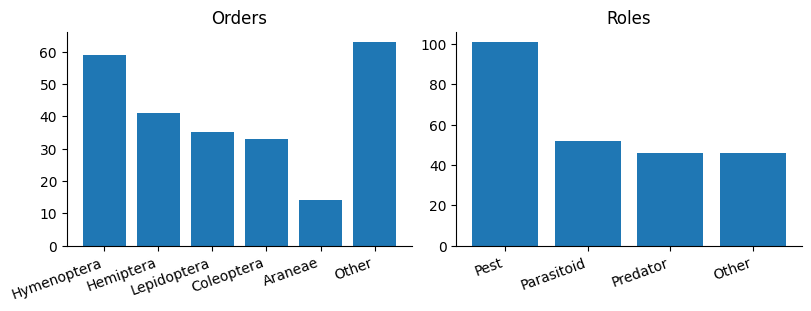

In [7]:
plot_barcharts(df1_test, train_test='test')

## Dataframes without the rows that GPT4 missed

In [8]:
# drop missed entries, but retain original indices:

df1_train_ = df1_train[df2_train['EID']!='']
df2_train_ = df2_train[df2_train['EID']!='']

df1_test_ = df1_test[df2_test['EID']!='']
df2_test_ = df2_test[df2_test['EID']!='']

In [9]:
missed_entries = sum(df2_train['EID']=='')
l = len(df1_train)

print('Training set:')
print('Missed species:\t',sum(df2_train['EID']==''),'out of',l,
      '= {:.1f}%'.format(100*missed_entries/l),
      '(corresponding to',len(np.unique(df1_train[df2_train['EID']=='']['EID'])),'out of 100 abstracts)')
print('Accuracy:\t {:.1f}%'.format(100*(l-missed_entries)/l))
print('\n')

species_found(df1_train, df2_train)

Training set:
Missed species:	 18 out of 649 = 2.8% (corresponding to 2 out of 100 abstracts)
Accuracy:	 97.2%


         EID    	|     Species Found  	|
--------------------------------------------------
2-s2.0-0000101789 	| 	 2 / 2   	|
2-s2.0-0000252648 	| 	 5 / 5   	|
2-s2.0-0001688927 	| 	 3 / 3   	|
2-s2.0-0005019556 	| 	 2 / 2   	|
2-s2.0-0006182411 	| 	 10 / 10   	|
2-s2.0-0008215387 	| 	 10 / 10   	|
2-s2.0-0021593437 	| 	 4 / 4   	|
2-s2.0-0024185618 	| 	 3 / 3   	|
2-s2.0-0024939691 	| 	 1 / 1   	|
2-s2.0-0027065837 	| 	 5 / 5   	|
2-s2.0-0027708505 	| 	 2 / 2   	|
2-s2.0-0027799605 	| 	 2 / 2   	|
2-s2.0-0028166139 	| 	 15 / 15   	|
2-s2.0-0028684035 	| 	 1 / 1   	|
2-s2.0-0028993233 	| 	 3 / 3   	|
2-s2.0-0028994795 	| 	 5 / 5   	|
2-s2.0-0030618395 	| 	 4 / 4   	|
2-s2.0-0030618427 	| 	 3 / 3   	|
2-s2.0-0031400560 	| 	 6 / 6   	|
2-s2.0-0031432732 	| 	 3 / 3   	|
2-s2.0-0031458929 	| 	 16 / 16   	|
2-s2.0-0032794850 	| 	 8 / 8   	|
2-s2.0-0032970080 	| 	 11 / 11   	|
2-s

In [10]:
missed_entries = sum(df2_test['EID']=='')
l = len(df1_test)

print('Test set:')
print('Missed species:\t',sum(df2_test['EID']==''),'out of',l,
      '= {:.1f}%'.format(100*missed_entries/l),
      '(corresponding to',len(np.unique(df1_test[df2_test['EID']=='']['EID'])),'out of 100 abstracts)')
print('Accuracy:\t {:.1f}%'.format(100*(l-missed_entries)/l))
print('\n')

species_found(df1_test, df2_test)

Test set:
Missed species:	 1 out of 245 = 0.4% (corresponding to 1 out of 100 abstracts)
Accuracy:	 99.6%


         EID    	|     Species Found  	|
--------------------------------------------------
2-s2.0-0001065549 	| 	 5 / 5   	|
2-s2.0-0024189410 	| 	 2 / 2   	|
2-s2.0-0024639644 	| 	 3 / 3   	|
2-s2.0-0024878871 	| 	 2 / 2   	|
2-s2.0-0026901758 	| 	 6 / 6   	|
2-s2.0-0027132805 	| 	 1 / 1   	|
2-s2.0-0028092372 	| 	 2 / 2   	|
2-s2.0-0028560901 	| 	 7 / 7   	|
2-s2.0-0028973895 	| 	 3 / 3   	|
2-s2.0-0030114202 	| 	 1 / 1   	|
2-s2.0-0030739264 	| 	 2 / 2   	|
2-s2.0-0031105231 	| 	 1 / 1   	|
2-s2.0-0031154434 	| 	 3 / 3   	|
2-s2.0-0031912434 	| 	 2 / 2   	|
2-s2.0-0031950831 	| 	 2 / 2   	|
2-s2.0-0032122262 	| 	 3 / 3   	|
2-s2.0-0032293772 	| 	 2 / 2   	|
2-s2.0-0032865018 	| 	 3 / 3   	|
2-s2.0-0033674416 	| 	 1 / 1   	|
2-s2.0-0033922525 	| 	 1 / 1   	|
2-s2.0-0034551082 	| 	 4 / 4   	|
2-s2.0-0035466062 	| 	 1 / 1   	|
2-s2.0-0035710146 	| 	 1 / 1   	|
2-s2.0-0036066779 

## Recall, precision and f1 of species extraction

### Over all species: 

In [11]:
# recall, precision (i.e., including hallucinations) and f1 of species extraction 

FP = 37 + 6  # (corresponding to 2 abstracts) 
TP = 624
FN = 18      # (corresponding to 2 abstracts) 
TN = 0 

rec = TP/(TP+FN)
pre = TP/(TP+FP)
f1 = 2*(pre*rec)/(pre+rec)

print("Training set:\nrecall:  \t{:5.1f}\nprecision:  \t{:5.1f}\nf1:\t\t{:5.1f}".format(rec*100, pre*100, f1*100))

FP = 0 
TP = 244
FN = 1      # (corresponding to 1 abstract) 
TN = 0 

rec = TP/(TP+FN)
pre = TP/(TP+FP)
f1 = 2*(pre*rec)/(pre+rec)

print("\nTest set:\nrecall:  \t{:5.1f}\nprecision:  \t{:5.1f}\nf1:\t\t{:5.1f}".format(rec*100, pre*100, f1*100))

Training set:
recall:  	 97.2
precision:  	 93.6
f1:		 95.3

Test set:
recall:  	 99.6
precision:  	100.0
f1:		 99.8


### Per abstract: 

In [12]:
import uncertainties 

# recall per abstract 
rpa_train = list(np.ones(98)) + [18/(18+2)] + [21/(21+16)]
rpa_test = list(np.ones(99)) + [0/(0+1)]

# precision per abstract 
ppa_train = list(np.ones(98)) + [18/(18+6)] + [21/(21+37)]
ppa_test = list(np.ones(100))

# convert into 'uncertainties' type: 
rpa_train = uncertainties.ufloat(np.mean(rpa_train), np.std(rpa_train))
ppa_train = uncertainties.ufloat(np.mean(ppa_train), np.std(ppa_train))

rpa_test = uncertainties.ufloat(np.mean(rpa_test), np.std(rpa_test))
ppa_test = uncertainties.ufloat(np.mean(ppa_test), np.std(ppa_test))

fpa_train = 2*rpa_train*ppa_train/(rpa_train+ppa_train)
fpa_test = 2*rpa_test*ppa_test/(rpa_test+ppa_test)

print("Training set:\nrecall:  \t{:5.1f}\nprecision:  \t{:5.1f}\nf1:\t\t{:5.1f}".format(rpa_train*100, ppa_train*100, fpa_train*100))
print("\nTest set:\nrecall:  \t{:5.1f}\nprecision:  \t{:5.1f}\nf1:\t\t{:5.1f}".format(rpa_test*100, ppa_test*100, fpa_test*100))

Training set:
recall:  	 99.5+/-  4.4
precision:  	 99.1+/-  6.8
f1:		 99.3+/-  4.1

Test set:
recall:  	 99.0+/-  9.9
precision:  	100.0+/-    0
f1:		 99.5+/-  5.0


# Taxonomy

## Training set

### 1. Inferred (Higher Level Taxonomy Prediction):

In [13]:
# indices of inferred class terms: 
inferred_c = np.array(list(np.arange(2,12))+list(np.arange(14,91))+list(np.arange(107,133))+list(np.arange(136,167))+list(np.arange(176,180))+list(np.arange(188,249))+[253,254,257,258,259,260,261]+list(np.arange(265,299))+list(np.arange(312,336))+list(np.arange(337,363))+list(np.arange(365,379))+list(np.arange(384,399))+list(np.arange(400,409))+list(np.arange(412,429))+list(np.arange(430,492))+list(np.arange(493,510))+[512,513,517]+list(np.arange(521,536))+[595]+list(np.arange(602,622))+list(np.arange(625,631))+list(np.arange(643,651)))-2
# indices of inferred order terms: 
inferred_o = np.array(list(np.arange(4,14))+list(np.arange(33,39))+[40,44,48,49,50,66,69,76,79,80,81,90]+list(np.arange(122,133))+list(np.arange(160,174))+list(np.arange(178,187))+list(np.arange(191,197))+list(np.arange(209,226))+[229]+list(np.arange(231,239))+[250]+list(np.arange(255,262))+list(np.arange(269,274))+list(np.arange(276,288))+list(np.arange(291,299))+[311]+list(np.arange(322,327))+[363,364]+list(np.arange(392,400))+list(np.arange(403,416))+list(np.arange(430,439))+[458,459,460]+list(np.arange(492,510))+[517]+list(np.arange(528,557))+list(np.arange(558,595))+list(np.arange(602,615)))-2
# indices of inferred family terms: 
inferred_f = np.array([5,6,7,8]+[33,34,35,36,37,39,40,44,48]+list(np.arange(57,66))+[69,81,90]+list(np.arange(122,133))+[160,161,162]+list(np.arange(165,172))+[174,175,178,179,180,181,182,184,185,186,191,192,193,209,210,211,212]+list(np.arange(214,226))+[229,231,234,236,237,238,241,242,243,244,245,250,256,258,259,270,271,272,273,296,297,298,311,326,363,364,392,393,399,406,407,408]+list(np.arange(417,429))+list(np.arange(493,505))+[507,508,509,517]+list(np.arange(528,557))+[596]+list(np.arange(602,611))+[613,614]+list(np.arange(643,651)))-2

len(inferred_c), len(inferred_o), len(inferred_f)

(487, 266, 184)

In [15]:
n = 0
n += len(df1_train.loc[inferred_c][df2_train.loc[inferred_c]['EID']!='']['Class']) # number of non-inferred class predictions (485)
n += len(df1_train.loc[inferred_o][df2_train.loc[inferred_o]['EID']!='']['Order']) # number of non-inferred order predictions (248)
n += len(df1_train.loc[inferred_f][df2_train.loc[inferred_f]['EID']!='']['Family']) # number of non-inferred family predictions (182)

# overall mistakes, as determined from taxonomic_mismatches_training.xlsx:

# exact (counting both minor and major mistakes as mistakes): 
mistakes = 22
PC_exact = (n-mistakes)/n

# approximate (only counting major mistakes as mistakes): 
mistakes = 15
PC_approx = (n-mistakes)/n

print('Overall:\n')
print('PC_exact:',100*round(PC_exact,4))
print('PC_approx:',100*round(PC_approx,4))

Overall:

PC_exact: 97.6
PC_approx: 98.36


In [232]:
print_accuracy_and_mismatches([inferred_c, inferred_o, inferred_f], df1_train, df2_train)

Accuracy and mismatches:

Class: 484 / 485 = 0.998
Index	Manual         	Predicted      
----------------------------------
2 	Insecta        	Coleoptera     

Order: 245 / 248 = 0.988
Index	Manual         	Predicted      
----------------------------------
2 	Coleoptera     	Carabidae      
294 	Hymenoptera    	Coleoptera     
515 	Hygrophila     	Pulmonata      

Family: 164 / 182 = 0.901
Index	Manual         	Predicted      
----------------------------------
158 	Urodontinae    	Anthribidae    
159 	Urodontinae    	Anthribidae    
169 	Meenoplidae    	Cicadellidae   
173 	Crambidae      	Pyralidae      
183 	Formicidae     	Myrmicinae     
218 	Ichneumonidae  	Chalcidoidea   
222 	Chalcididae    	Pteromalidae   
223 	Ichneumonidae  	Chalcididae    
294 	Braconidae     	Cleridae       
296 	Braconidae     	Aphidiinae     
415 	Eulophidae     	Pteromalidae   
417 	Figitidae      	Cynipidae      
527 	Delphacidae    	Cicadellidae   
552 	Cicadellidae   	Delphacidae    
606 	Braconidae

In [234]:
# the two major mistakes in Order:

eids = df1_train_.loc[[294,515]]['EID']

# print(len(df1_train_[df1_train_['EID']=='2-s2.0-77957969950']))  # 1/3 are major mistakes
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-4243173915'])) # 1/4 are major mistakes

# accuracies per abstract: 
arr = list(np.ones(98))+[2/3]+[3/4]
print('Accuracy per abstract (Order): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Order): 99.4 +\- 4.1


In [230]:
# the thirteen major mistakes in Family:

eids = df1_train_.loc[[169,173,218,222,223,294,415,417,527,552,611,646,647]]['EID']

# arise from eigth abstracts: 
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-0037800443']))  # 2/9 are major mistakes
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-19944366420'])) # 3/18 are major mistakes
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-77957969950'])) # 1/3 are major mistakes
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-85019767155'])) # 2/13 are major mistakes 
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-62149141341'])) # 1/10 are major mistakes
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-33845901783'])) # 1/18 are major mistakes
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-84988695777'])) # 1/13 are major mistakes 
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-85045837897'])) # 2/8 are major mistakes

# accuracies per abtract: 
arr = list(np.ones(92))+[7/9,15/18,2/3,11/13,9/10,17/18,12/13,6/8]
print('Accuracy per abstract (Family): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Family): 98.6 +\- 5.2


In [16]:
arr = list(np.ones(92))+[3/4,7/9,15/18,2/6,11/13,9/10,17/18,12/13,6/8]
print('Accuracy per abstract (Overall): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Overall): 98.1 +\- 8.0


#### Calculating the number of taxonomic terms in family rank, for the abstracts which contained major mistakes

In [182]:
l = 0
eids=[]
for i in [294,169,173,218,222,223,294,415,417,527,552,611,646,647]: # indices of rows which contained a major mistake in the family rank
    eid=df1_train_.loc[i]['EID']
    if not eid in eids:
        eids.append(eid)

print('Number of abstracts:',len(eids))

Number of abstracts: 8


In [186]:
s = 0
for inf, lab in zip([inferred_f],['Family']):
    arr1 = df1_train.loc[inf][df2_train.loc[inf]['EID']!=''][[lab,'EID']] # just the inferred family terms and eids
    for eid in eids:
        s += len(arr1[arr1['EID']==eid]) 

print('Inferred taxonomic terms in the family rank from selected abstracts:',s,'out of 182 = {:.1f}%'.format(100*s/182)) 

Inferred taxonomic terms in the family rank from selected abstracts: 81 out of 182 = 44.5%


### 2. Non-inferred (Taxonomic Named Entity Recognition):

In [18]:
# indices of non-inferred class terms: 
noninf_c = list(set(np.arange(0,649))-set(inferred_c))
# indices of non-inferred order terms: 
noninf_o = list(set(np.arange(0,649))-set(inferred_o))
# indices of non-inferred family terms: 
noninf_f = list(set(np.arange(0,649))-set(inferred_f))

len(noninf_c), len(noninf_o), len(noninf_f)

(162, 383, 465)

In [19]:
n = 0
n += len(df1_train.loc[noninf_c][df2_train.loc[noninf_c]['EID']!='']['Class']) # number of non-inferred class predictions (146)
n += len(df1_train.loc[noninf_o][df2_train.loc[noninf_o]['EID']!='']['Order']) # number of non-inferred order predictions (383)
n += len(df1_train.loc[noninf_f][df2_train.loc[noninf_f]['EID']!='']['Family']) # number of non-inferred family predictions (449)
n += len(df1_train.loc[list(np.arange(0,649))][df2_train.loc[list(np.arange(0,649))]['EID']!='']['Genus']) # number of non-inferred genus predictions (631)
n += len(df1_train.loc[list(np.arange(0,649))][df2_train.loc[list(np.arange(0,649))]['EID']!='']['Species']) # number of non-inferred species predictions (631)

# overall mistakes, as determined from taxonomic_mismatches_training.xlsx:

# exact (counting both minor and major mistakes as mistakes): 
mistakes = 44
PC_exact = (n-mistakes)/n

# approximate (only counting major mistakes as mistakes): 
mistakes = 1
PC_approx = (n-mistakes)/n

print('Overall:\n')
print('PC_exact:',100*round(PC_exact,4))
print('PC_approx:',100*round(PC_approx,4))

Overall:

PC_exact: 98.04
PC_approx: 99.96000000000001


In [17]:
print_accuracy_and_mismatches([noninf_c, noninf_o, noninf_f, noninf_g, noninf_s], df1_train, df2_train)

Accuracy and mismatches:

Class: 143 / 146 = 0.979
Index	Manual         	Predicted      
----------------------------------
516 	Insecta        	Insect         
517 	Insecta        	Insect         
518 	Insecta        	Insect         

Order: 377 / 383 = 0.984
Index	Manual         	Predicted      
----------------------------------
623 	Heteroptera    	Hemiptera      
624 	Heteroptera    	Hemiptera      
625 	Heteroptera    	Hemiptera      
626 	Heteroptera    	Hemiptera      
627 	Heteroptera    	Hemiptera      
628 	Heteroptera    	Hemiptera      

Family: 443 / 449 = 0.987
Index	Manual         	Predicted      
----------------------------------
52 	Doryctinae     	Braconidae     
53 	Doryctinae     	Braconidae     
54 	Braconinae     	Braconidae     
523 	Psylloidea     	Psyllidae      
638 	Anthomylidae   	Anthomyiidae   
639 	Fulgoroidae    	Fulgoridae     


In [217]:
# the one major mistake in the Species rank: 
# print(len(df1_train_[df1_train_['EID']=='2-s2.0-0036212873'])) # 1/8 are major mistakes 

arr = list(np.ones(99))+[7/8]
print('Accuracy per abstract (Species): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Species): 99.9 +\- 1.2


In [28]:
arr = list(np.ones(99))+[7/8]
print('Accuracy per abstract (Overall): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Overall): 99.9 +\- 1.2


### 3. All taxonomic terms (training)

In [37]:
# overall (inferred and non-inferred for the training set) 

# mistakes determined from taxonomic_mismatches_training.xlsx
l = len(df1_train_)*5
# exact (counting both minor and major mistakes as mistakes): 
mistakes = 22+44
PC_exact = (l-mistakes)/l

# approximate (only counting major mistakes as mistakes): 
mistakes = 15+1
PC_approx = (l-mistakes)/l

print('Overall:\n')
print('PC_exact:',round(PC_exact,3))
print('PC_approx:',round(PC_approx,3))


arr_inf = list(np.ones(92))+[3/4,7/9,15/18,2/6,11/13,9/10,17/18,12/13,6/8]
arr_noninf = list(np.ones(99))+[7/8]
arr = arr_inf + arr_noninf
print('PC*_approx per abstract (Overall): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Overall:

PC_exact: 0.979
PC_approx: 0.995
PC*_approx per abstract (Overall): 99.0 +\- 5.8


In [218]:
_ = print_taxonomic_mistakes(df1_train_, df2_train_)

Mismatches:

Class | 4
Index      | Manual label              | Prediction           | Species (manual)               | Species (prediction)          
----------------------------------------------------------------------------------------------------
         2 | Insecta                   | Coleoptera           | Abax parallelepipedus          | Abax Abax parallelepipedus    
       516 | Insecta                   | Insect               | Eristalinus aeneus             | Eristalinus aeneus            
       517 | Insecta                   | Insect               | Ischiodon scutellaris          | Ischiodon scutellaris         
       518 | Insecta                   | Insect               | Episyrphus balteatus           | Episyrphus balteatus          


Order | 9
Index      | Manual label              | Prediction           | Species (manual)               | Species (prediction)          
------------------------------------------------------------------------------------------------

## Test set

### 1. Inferred (Higher level taxonomy prediction):

In [20]:
inferred_c = np.array([2,3,4,5,6]+list(np.arange(8,28))+[31,32,33]+list(np.arange(37,54))+[55]+list(np.arange(71,83))+[84,85,87,89]+list(np.arange(93,105))+[108,112,113,114,115,116,117,119,120]+list(np.arange(122,130))+[131,132,135,136,142,148,150,151,153,154,155,158,159,160,161,163,164,165,166]+list(np.arange(175,198))+list(np.arange(199,219))+[221,222]+list(np.arange(224,230))+[233,234,237,238]+list(np.arange(240,247)))-2
inferred_o = np.array(list(np.arange(4,14))+[15,16,17]+list(np.arange(28,35))+[36,38,39,49,51,52,53]+list(np.arange(55,61))+list(np.arange(65,70))+[82,86,87,88,89]+list(np.arange(93,105))+[109,115,119,120,121]+list(np.arange(123,133))+[135,136,138,140]+list(np.arange(143,153))+[156,158,159,160,161,164,165,166,167,168,173,174]+list(np.arange(176,183))+[198,201,202]+list(np.arange(209,216))+[217,218,219,221,227,228,230,231,232,233,235,236,237,238,246])-2
inferred_f = np.array(list(np.arange(4,14))+[15,16,17]+list(np.arange(28,35))+[36,38,39,40,41,42,49,51,52,53,56,57,58,59,60]+list(np.arange(65,70))+[82]+list(np.arange(88,105))+[109,119,120,121]+list(np.arange(124,133))+[135,136,138,140]+list(np.arange(144,153))+[156,158,159,160,161,164,165,166,167,168,173,174]+list(np.arange(176,183))+[198,201,202]+list(np.arange(209,220))+[221,231,232,233,246])-2

len(inferred_c), len(inferred_o), len(inferred_f)

(172, 128, 122)

In [21]:
n = 0
n += len(df1_test.loc[inferred_c][df2_test.loc[inferred_c]['EID']!='']['Class']) # number of non-inferred class predictions (171)
n += len(df1_test.loc[inferred_o][df2_test.loc[inferred_o]['EID']!='']['Order']) # number of non-inferred order predictions (127)
n += len(df1_test.loc[inferred_f][df2_test.loc[inferred_f]['EID']!='']['Family']) # number of non-inferred family predictions (121)

# overall mistakes, as determined from taxonomic_mismatches_test.xlsx:

# exact (counting both minor and major mistakes as mistakes): 
mistakes = 23
PC_exact = (n-mistakes)/n

# approximate (only counting major mistakes as mistakes): 
mistakes = 7
PC_approx = (n-mistakes)/n

print('Overall:\n')
print('PC_exact:',100*round(PC_exact,3))
print('PC_approx:',100*round(PC_approx,3))

Overall:

PC_exact: 94.5
PC_approx: 98.3


In [13]:
print_accuracy_and_mismatches([inferred_c, inferred_o, inferred_f], df1_test, df2_test)

Accuracy and mismatches:

Class: 159 / 171 = 0.93
Index	Manual         	Predicted      
----------------------------------
53 	Chromadorea    	Nematoda       
117 	Chromadorea    	Nematoda       
118 	Chromadorea    	Nematoda       
148 	Chromadorea    	Secernentea    
149 	Chromadorea    	Secernentea    
162 	Chromadorea    	Secernentea    
163 	Chromadorea    	Secernentea    
164 	Chromadorea    	Secernentea    
179 	Chromadorea    	Nematoda       
225 	Chromadorea    	Nematoda       
226 	Chromadorea    	Nematoda       
236 	Platyhelminthes	Turbellaria    

Order: 123 / 127 = 0.969
Index	Manual         	Predicted      
----------------------------------
3 	Hygrophila     	Basommatophora 
30 	Trombidiformes 	Acari          
219 	Blattodea      	Isoptera       
236 	Turbellaria    	Polycladida    

Family: 114 / 121 = 0.942
Index	Manual         	Predicted      
----------------------------------
3 	Bulinidae      	Planorbidae    
4 	Erebidae       	Noctuidae      
10 	Eumenidae      	

In [234]:
# the one major mistake in Class:

# print(df1_test_.loc[236]['EID'])

# print(len(df1_test_[df1_test_['EID']=='2-s2.0-0035466062'])) # 1/1 are major mistakes
arr = list(np.ones(99))+[0/1]
print('Accuracy per abstract (Class): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Class): 99.0 +\- 9.9


In [235]:
# the two major mistakes in Order:

# print(df1_test_.loc[[3,219]]['EID'])

# print(len(df1_test_[df1_test_['EID']=='2-s2.0-0024189410'])) # 1/2 are major mistakes
# print(len(df1_test_[df1_test_['EID']=='2-s2.0-33846412291'])) # 1/1 are major mistakes

arr = list(np.ones(98))+[1/2,0/1]
print('Accuracy per abstract (Order): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Order): 98.5 +\- 11.1


In [236]:
# the four major mistakes in Family:

# print(df1_test_.loc[[4,10,177,178]]['EID'])

# arising from two abstracts: 
# print(len(df1_test_[df1_test_['EID']=='2-s2.0-32544437705'])) # 2/8 are major mistakes
# print(len(df1_test_[df1_test_['EID']=='2-s2.0-0026901758']))  # 2/6 are major mistakes

arr = list(np.ones(98))+[6/8,4/6]
print('Accuracy per abstract (Family): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Family): 99.4 +\- 4.1


In [27]:
arr = list(np.ones(95))+[0/1,1/2,0/1,6/8,4/6]
print('Accuracy per abstract (Overall): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Overall): 96.9 +\- 15.3


#### Calculating the number of taxonomic terms in family rank, for the abstracts which contained major mistakes

In [243]:
l = 0
eids=[]
for i in [3,4,10,118,164,177,178]:
    eid=df1_test_.loc[i]['EID']
    if not eid in eids:
        eids.append(eid)
        l += len(df1_test_[df1_test_['EID']==eid])

print('Number of abstracts:',len(eids))

Number of abstracts: 5


In [244]:
s = 0
for inf, lab in zip([inferred_f],['Family']):
    arr1 = df1_test.loc[inf][df2_test.loc[inf]['EID']!=''][[lab,'EID']]
    for eid in eids:
        s += len(arr1[arr1['EID']==eid])

print('Inferred taxonomic terms in the family rank from selected abstracts:',s,'out of 121 = {:.1f}%'.format(100*s/121)) 

Inferred taxonomic terms in the family rank from selected abstracts: 23 out of 121 = 19.0%


### 2. Non-inferred (Taxonomic Named Entity Recognition):

In [29]:
noninf_c = list(set(np.arange(0,245))-set(inferred_c))
noninf_o = list(set(np.arange(0,245))-set(inferred_o))
noninf_f = list(set(np.arange(0,245))-set(inferred_f))

len(noninf_c), len(noninf_o), len(noninf_f)

(73, 117, 123)

In [34]:
n = 0
n += len(df1_test.loc[noninf_c][df2_test.loc[noninf_c]['EID']!='']['Class']) # number of non-inferred class predictions (73)
n += len(df1_test.loc[noninf_o][df2_test.loc[noninf_o]['EID']!='']['Order']) # number of non-inferred order predictions (117)
n += len(df1_test.loc[noninf_f][df2_test.loc[noninf_f]['EID']!='']['Family']) # number of non-inferred family predictions (123)
n += len(df1_test.loc[list(np.arange(0,245))][df2_test.loc[list(np.arange(0,245))]['EID']!='']['Genus']) # number of non-inferred genus predictions (244)
n += len(df1_test.loc[list(np.arange(0,245))][df2_test.loc[list(np.arange(0,245))]['EID']!='']['Species']) # number of non-inferred species predictions (244)

# overall mistakes, as determined from taxonomic_mismatches_test.xlsx:

# exact (counting both minor and major mistakes as mistakes): 
mistakes = 26
PC_exact = (n-mistakes)/n

# approximate (only counting major mistakes as mistakes): 
mistakes = 3
PC_approx = (n-mistakes)/n

print('Overall:\n')
print('PC_exact:',100*round(PC_exact,3))
print('PC_approx:',100*round(PC_approx,4))

123
Overall:

PC_exact: 96.8
PC_approx: 99.63


In [250]:
print_accuracy_and_mismatches([noninf_c, noninf_o, noninf_f], df1_test, df2_test)

Accuracy and mismatches:

Class: 73 / 73 = 1.0
Index	Manual         	Predicted      
----------------------------------

Order: 107 / 117 = 0.915
Index	Manual         	Predicted      
----------------------------------
43 	Heteroptera    	Hemiptera      
60 	Homoptera      	Hemiptera      
68 	Homoptera      	Hemiptera      
82 	Acari          	Trombidiformes 
140 	Acari          	Trombidiformes 
170 	Homoptera      	Hemiptera      
181 	Acari          	Trombidiformes 
182 	Acari          	Trombidiformes 
221 	Homoptera      	Hemiptera      
232 	Acari          	Mesostigmata   

Family: 121 / 123 = 0.984
Index	Manual         	Predicted      
----------------------------------
60 	Aphididea      	Aphididae      
238 	Ibhneumonidae  	Ichneumonidae  


In [251]:
# the two major mistakes in Order:

# print(df1_test_.loc[[181,182]]['EID'])

# print(len(df1_test_[df1_test_['EID']=='2-s2.0-84937421125'])) # 2/2 are major mistakes

arr = list(np.ones(99))+[0/2]
print('Accuracy per abstract (Order): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Order): 99.0 +\- 9.9


In [252]:
# the one major mistake in Species:

# print(df1_test_.loc[157])

# print(len(df1_test_[df1_test_['EID']=='2-s2.0-0001065549'])) # 1/5 are major mistakes

arr = list(np.ones(99))+[4/5]
print('Accuracy per abstract (Species): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Species): 99.8 +\- 2.0


In [26]:
arr = list(np.ones(98))+[0/2]+[4/5]

print('Accuracy per abstract (Overall): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Accuracy per abstract (Overall): 98.8 +\- 10.1


### All taxonomic terms (test)

In [38]:
# overall (inferred and non-inferred for test set)

# determined from taxonomic_mismatches_test.xlsx
l = len(df1_test_)*5

# exact (counting both minor and major mistakes as mistakes): 
mistakes = 23+26
PC_exact = (l-mistakes)/l

# approximate (only counting major mistakes as mistakes): 
mistakes = 7+3
PC_approx = (l-mistakes)/l

print('Overall:\n')
print('PC_exact:',round(PC_exact,3))
print('PC_approx:',round(PC_approx,3))

arr_inf = list(np.ones(95))+[0/1,1/2,0/1,6/8,4/6]
arr_noninf = list(np.ones(98))+[0/2]+[4/5]
arr = arr_inf + arr_noninf
print('PC*_approx per abstract (Overall): {:.1f} +\- {:.1f}'.format(np.mean(arr)*100,np.std(arr)*100))

Overall:

PC_exact: 0.96
PC_approx: 0.992
PC*_approx per abstract (Overall): 97.9 +\- 13.0


In [253]:
_ = print_taxonomic_mistakes(df1_test_, df2_test_)

Mismatches:

Class | 12
Index      | Manual label              | Prediction           | Species (manual)               | Species (prediction)          
----------------------------------------------------------------------------------------------------
        53 | Chromadorea               | Nematoda             | Steinernema carpocapsae        | Steinernema carpocapsae       
       117 | Chromadorea               | Nematoda             | Steinernema spp.               | Steinernema spp.              
       118 | Chromadorea               | Nematoda             | Heterorhabditis spp.           | Heterorhabditis spp.          
       148 | Chromadorea               | Secernentea          | Steinernema carpocapsae        | Steinernema carpocapsae       
       149 | Chromadorea               | Secernentea          | Oscheius chongmingensis        | Oscheius chongmingensis       
       162 | Chromadorea               | Secernentea          | Steinernema glaseri            | Steinernem

# Roles

## Training set 

In [23]:
np.unique(df1_train_['Role'])

array(['', 'Biological Control Agent', 'Herbivore', 'Host',
       'Hyperparasitoid', 'Leaf miner', 'Parasitoid', 'Pest',
       'Pollinator', 'Predator', 'Prey'], dtype=object)

In [24]:
np.unique(df2_train_['Role'])

array(['', 'Biological Control', 'Biological Control Agent',
       'Biological control agent', 'Herbivore', 'Host', 'Hyperparasitoid',
       'Not mentioned', 'Parasitoid', 'Pest', 'Pollinator', 'Predator',
       'Prey', 'Prey, Host'], dtype=object)

In [37]:
# group these terms into common roles: 

roles1 = df1_train_[['Role','EID']].copy()
roles2 = df2_train_[['Role','EID']].copy()

for i in list(roles1.index):
    if roles1.loc[i]['Role']=='Biological Control Agent':
        roles1.loc[i]['Role']='B.C.A.'
    if (roles2.loc[i]['Role']=='Biological control agent') or (roles2.loc[i]['Role']=='Biological Control') or (roles2.loc[i]['Role']=='Biological Control Agent'):
        roles2.loc[i]['Role']='B.C.A.'
    if roles1.loc[i]['Role']=='Hyperparasitoid':
        roles1.loc[i]['Role']='H. Parasitoid'
    if roles2.loc[i]['Role']=='Hyperparasitoid':
        roles2.loc[i]['Role']='H. Parasitoid'   
    if (roles2.loc[i]['Role']=='Host') or (roles2.loc[i]['Role']=='Prey') or (roles2.loc[i]['Role']=='Prey, Host'):
        roles2.loc[i]['Role']='Prey/Host'
    if (roles1.loc[i]['Role']=='Host') or (roles1.loc[i]['Role']=='Prey'):
        roles1.loc[i]['Role']='Prey/Host'
    if (roles2.loc[i]['Role']=='Not mentioned') or (roles2.loc[i]['Role']==''):
        roles2.loc[i]['Role']='Unclear'
    if roles1.loc[i]['Role']=='':
        roles1.loc[i]['Role']='Unclear'
    if (roles1.loc[i]['Role']=='Herbivore') or (roles1.loc[i]['Role']=='Leaf miner') or (roles1.loc[i]['Role']=='Pollinator'):
        roles1.loc[i]['Role']='Other'
    if (roles2.loc[i]['Role']=='Herbivore') or (roles2.loc[i]['Role']=='Pollinator'):
        roles2.loc[i]['Role']='Other'

print(np.unique(roles1['Role']))
print(np.unique(roles2['Role']))

['B.C.A.' 'H. Parasitoid' 'Other' 'Parasitoid' 'Pest' 'Predator'
 'Prey/Host' 'Unclear']
['B.C.A.' 'H. Parasitoid' 'Other' 'Parasitoid' 'Pest' 'Predator'
 'Prey/Host' 'Unclear']


In [28]:
labels = ['Predator', 'Parasitoid','Pest','B.C.A.','H. Parasitoid','Nat. Enemy','Prey/Host','Other','Unclear']

/var/folders/2l/62xwcgws5mx86y0bhqmkbpqc0000gn/T/ipykernel_53247/2015775838.py:174: RuntimeWarning: invalid value encountered in divide
  cm_perc = cm / cm_sum.astype(float) * 100


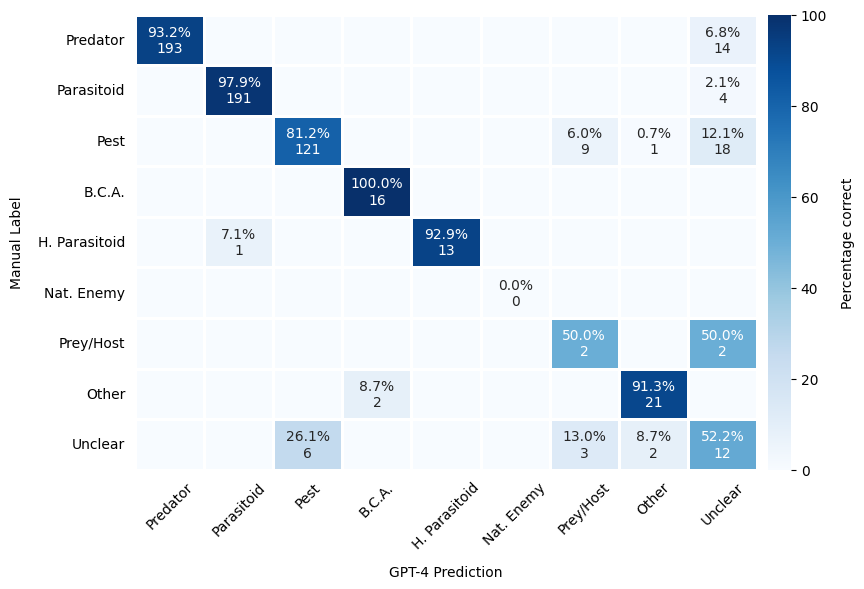



               precision    recall  f1-score   support

     Predator      1.000     0.932     0.965       207
   Parasitoid      0.995     0.979     0.987       195
         Pest      0.953     0.812     0.877       149
       B.C.A.      0.889     1.000     0.941        16
H. Parasitoid      1.000     0.929     0.963        14
   Nat. Enemy      0.000     0.000     0.000         0
    Prey/Host      0.143     0.500     0.222         4
        Other      0.875     0.913     0.894        23
      Unclear      0.240     0.522     0.329        23

    micro avg      0.902     0.902     0.902       631
    macro avg      0.677     0.732     0.686       631
 weighted avg      0.947     0.902     0.920       631



In [35]:
plot_confusion_matrix(roles1['Role'], roles2['Role'], labels=labels, xlab='GPT-4 Prediction', ylab='Manual Label', train_test='train',
                      figsize=(9,6), xrot=45, filename='cm_roles')

In [38]:
# scores per abstract 

eids = np.unique(df1_train_['EID'])

scores_per_abstract(roles1, roles2, eids, header='Role', labels=labels)

Label: Predator (num abstracts: 54)
precision:	100.0 +/- 0.0
recall:		98.4 +/- 11.8
f1:		98.6 +/- 10.5


Label: Parasitoid (num abstracts: 35)
precision:	97.2 +/- 16.4
recall:		97.1 +/- 11.6
f1:		98.1 +/- 7.7


Label: Pest (num abstracts: 68)
precision:	96.8 +/- 17.5
recall:		88.8 +/- 30.9
f1:		99.3 +/- 5.4


Label: B.C.A. (num abstracts: 5)
precision:	71.4 +/- 45.2
recall:		100.0 +/- 0.0
f1:		100.0 +/- 0.0


Label: H. Parasitoid (num abstracts: 6)
precision:	100.0 +/- 0.0
recall:		83.3 +/- 37.3
f1:		100.0 +/- 0.0


Label: Nat. Enemy (num abstracts: 0)
precision:	nan +/- nan
recall:		nan +/- nan
f1:		nan +/- nan




/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Label: Prey/Host (num abstracts: 3)
precision:	7.4 +/- 21.0
recall:		33.3 +/- 47.1
f1:		80.0 +/- 0.0


Label: Other (num abstracts: 7)
precision:	62.5 +/- 48.4
recall:		71.4 +/- 45.2
f1:		100.0 +/- 0.0


Label: Unclear (num abstracts: 9)
precision:	37.5 +/- 48.4
recall:		33.3 +/- 47.1
f1:		100.0 +/- 0.0




## Test set

In [39]:
np.unique(df1_test_['Role'])

array(['', 'Biological Control Agent', 'Ectoparasite', 'Herbivore',
       'Host', 'Hyperparasitoid', 'Leaf Miner', 'Mosquito',
       'Natural Enemy', 'Parasitoid', 'Pest', 'Predator', 'Prey',
       'Scavenger'], dtype=object)

In [40]:
np.unique(df2_test_['Role'])

array(['', 'Biological Control Agent', 'Biological control agent',
       'Competitor', 'Herbivore', 'Host', 'Hyperparasitoid', 'Parasitoid',
       'Pest', 'Predator', 'Prey', 'Scavenger', 'Secondary Pest'],
      dtype=object)

In [41]:
roles1 = df1_test_[['Role','EID']].copy()
roles2 = df2_test_[['Role','EID']].copy()

for i in list(roles1.index):
    if roles1.loc[i]['Role']=='Biological Control Agent':
        roles1.loc[i]['Role']='B.C.A.'
    if (roles2.loc[i]['Role']=='Biological Control Agent') or (roles2.loc[i]['Role']=='Biological control agent'):
        roles2.loc[i]['Role']='B.C.A.'
    if roles1.loc[i]['Role']=='Hyperparasitoid':
        roles1.loc[i]['Role']='H. Parasitoid'
    if roles2.loc[i]['Role']=='Hyperparasitoid':
        roles2.loc[i]['Role']='H. Parasitoid'  
    if (roles2.loc[i]['Role']=='Host') or (roles2.loc[i]['Role']=='Prey'):
        roles2.loc[i]['Role']='Prey/Host'
    if (roles1.loc[i]['Role']=='Host') or (roles1.loc[i]['Role']=='Prey'):
        roles1.loc[i]['Role']='Prey/Host'
    if (roles2.loc[i]['Role']=='Not mentioned') or (roles2.loc[i]['Role']==''):
        roles2.loc[i]['Role']='Unclear'
    if roles1.loc[i]['Role']=='':
        roles1.loc[i]['Role']='Unclear'
    if (roles1.loc[i]['Role']=='Herbivore') or (roles1.loc[i]['Role']=='Leaf Miner') or (roles1.loc[i]['Role']=='Scavenger') or (roles1.loc[i]['Role']=='Ectoparasite') or (roles1.loc[i]['Role']=='Mosquito'):
        roles1.loc[i]['Role']='Other'
    if (roles2.loc[i]['Role']=='Herbivore') or (roles2.loc[i]['Role']=='Pollinator') or (roles2.loc[i]['Role']=='Scavenger') or (roles2.loc[i]['Role']=='Competitor'):
        roles2.loc[i]['Role']='Other'
    if roles2.loc[i]['Role']=='Secondary Pest':
        roles2.loc[i]['Role']='Pest'
    if roles1.loc[i]['Role']=='Natural Enemy':
        roles1.loc[i]['Role']='Nat. Enemy'

print(np.unique(roles1['Role']))
print(np.unique(roles2['Role']))

['B.C.A.' 'H. Parasitoid' 'Nat. Enemy' 'Other' 'Parasitoid' 'Pest'
 'Predator' 'Prey/Host' 'Unclear']
['B.C.A.' 'H. Parasitoid' 'Other' 'Parasitoid' 'Pest' 'Predator'
 'Prey/Host' 'Unclear']


In [ ]:
labels = ['Predator', 'Parasitoid','Pest','B.C.A.','H. Parasitoid','Nat. Enemy','Prey/Host','Other','Unclear']

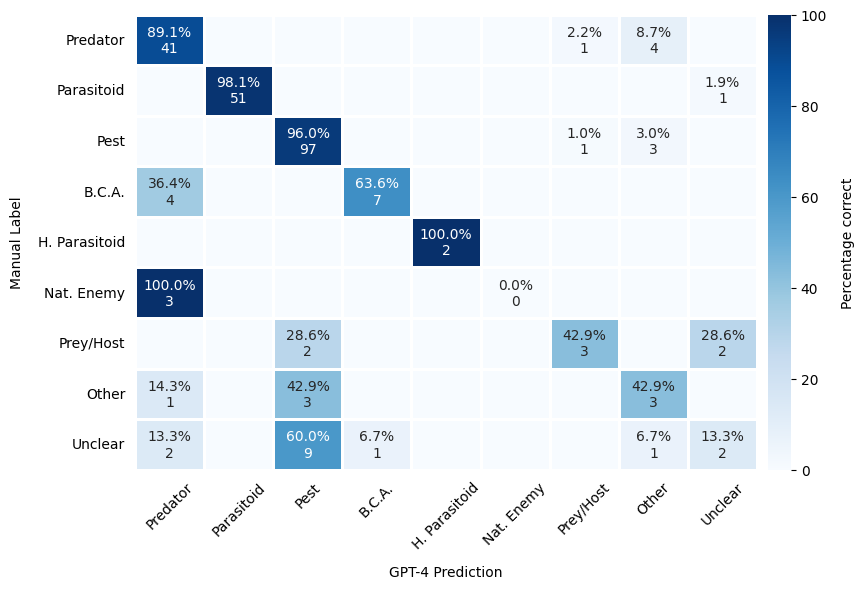



               precision    recall  f1-score   support

     Predator      0.804     0.891     0.845        46
   Parasitoid      1.000     0.981     0.990        52
         Pest      0.874     0.960     0.915       101
       B.C.A.      0.875     0.636     0.737        11
H. Parasitoid      1.000     1.000     1.000         2
   Nat. Enemy      0.000     0.000     0.000         3
    Prey/Host      0.600     0.429     0.500         7
        Other      0.273     0.429     0.333         7
      Unclear      0.400     0.133     0.200        15

     accuracy                          0.844       244
    macro avg      0.647     0.607     0.613       244
 weighted avg      0.824     0.844     0.827       244



In [42]:
plot_confusion_matrix(roles1['Role'], roles2['Role'], labels=labels, xlab='GPT-4 Prediction', ylab='Manual Label', train_test='test',
                      figsize=(9,6), xrot=45, filename='cm_roles')

In [43]:
# scores per abstract 

eids = np.unique(df1_test_['EID'])

scores_per_abstract(roles1, roles2, eids, header='Role', labels=labels)

Label: Predator (num abstracts: 19)
precision:	76.0 +/- 42.7
recall:		95.6 +/- 18.6
f1:		96.2 +/- 15.9


Label: Parasitoid (num abstracts: 23)
precision:	100.0 +/- 0.0
recall:		98.9 +/- 5.1
f1:		99.4 +/- 2.9


Label: Pest (num abstracts: 73)
precision:	89.9 +/- 30.2
recall:		96.6 +/- 17.2
f1:		99.5 +/- 3.9


Label: B.C.A. (num abstracts: 7)
precision:	83.3 +/- 37.3
recall:		71.4 +/- 45.2
f1:		100.0 +/- 0.0


Label: H. Parasitoid (num abstracts: 1)
precision:	100.0 +/- 0.0
recall:		100.0 +/- 0.0
f1:		100.0 +/- 0.0


Label: Nat. Enemy (num abstracts: 1)
precision:	nan +/- nan
recall:		0.0 +/- 0.0
f1:		nan +/- nan




/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/daanscheepens/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Label: Prey/Host (num abstracts: 6)
precision:	60.0 +/- 49.0
recall:		50.0 +/- 50.0
f1:		100.0 +/- 0.0


Label: Other (num abstracts: 5)
precision:	42.9 +/- 49.5
recall:		60.0 +/- 49.0
f1:		100.0 +/- 0.0


Label: Unclear (num abstracts: 10)
precision:	50.0 +/- 50.0
recall:		20.0 +/- 40.0
f1:		100.0 +/- 0.0




# Exra: Pest Industry Types

### Training set:

In [177]:
x = df1_train_[['Associated With','EID']].copy()
y = df2_train_[['Associated With','EID']].copy()

print(np.unique(x['Associated With']))
print(np.unique(y['Associated With']))

['' 'Agriculture' 'Forestry' 'Unclear']
['' 'Agriculture' 'Agroecosystems' 'Environment' 'Forestry'
 'Not mentioned']


In [178]:
for i in list(x.index): 
    if x.loc[i]['Associated With']=='Unclear':
        x.loc[i]['Associated With']='Unknown\nor unclear'
    if x.loc[i]['Associated With']=='':
        x.loc[i]['Associated With']='Unknown\nor unclear'
    if y.loc[i]['Associated With']=='Not mentioned':
        y.loc[i]['Associated With']='Unknown\nor unclear'
    if y.loc[i]['Associated With']=='':
        y.loc[i]['Associated With']='Unknown\nor unclear'
    if y.loc[i]['Associated With']=='Agroecosystems':
        y.loc[i]['Associated With']='Agriculture'
    if y.loc[i]['Associated With']=='Environment':
        y.loc[i]['Associated With']='Unknown\nor unclear'

labels = ['Agriculture','Forestry','Unknown\nor unclear']

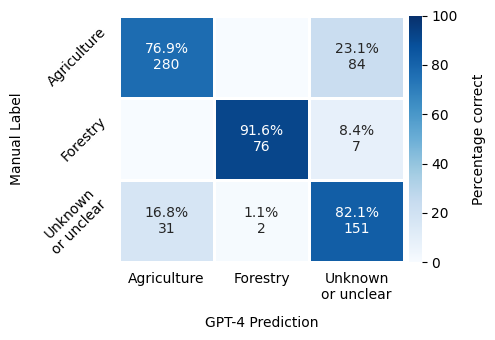



                    precision    recall  f1-score   support

       Agriculture      0.900     0.769     0.830       364
          Forestry      0.974     0.916     0.944        83
Unknown
or unclear      0.624     0.821     0.709       184

          accuracy                          0.803       631
         macro avg      0.833     0.835     0.828       631
      weighted avg      0.829     0.803     0.809       631



In [179]:
plot_confusion_matrix(x['Associated With'], y['Associated With'], labels=labels, xlab='GPT-4 Prediction', ylab='Manual Label', train_test='train',
                      figsize=(5,3.5), xrot=0, yrot=45, filename='cm_industry')

In [180]:
# Comparison with Pest_Industry_Hallucinations.pdf: 

num_abstracts = 9
num_species = 33

print('Abstracts where mismatched pest type was likely to be hallucinated: \t2/9')
print('Corresponding to 7/33 species (%s)'%np.round(7/33,3))

print('\nAbstracts where mismatched pest type turned out to be correct: \t\t5/9')
print('Corresponding to 17/33 species (%s)'%np.round(17/33,3))

Abstracts where mismatched pest type was likely to be hallucinated: 	2/9
Corresponding to 7/33 species (0.212)

Abstracts where mismatched pest type turned out to be correct: 		5/9
Corresponding to 17/33 species (0.515)


In [181]:
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-0024939691')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-0028993233')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-62149141341')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-85052445922')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-0036212873')]='Agriculture'

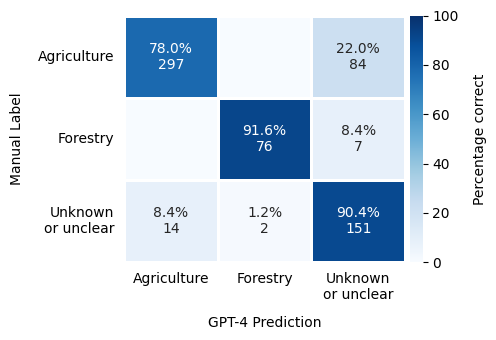



                    precision    recall  f1-score   support

       Agriculture      0.955     0.780     0.858       381
          Forestry      0.974     0.916     0.944        83
Unknown
or unclear      0.624     0.904     0.738       167

          accuracy                          0.830       631
         macro avg      0.851     0.866     0.847       631
      weighted avg      0.870     0.830     0.838       631



In [182]:
plot_confusion_matrix(x['Associated With'], y['Associated With'], labels=labels, xlab='GPT-4 Prediction', ylab='Manual Label', train_test='train',
                      figsize=(5,3.5), xrot=0, filename='cm_industry')

### Test set

In [183]:
x = df1_test_[['Associated With','EID']].copy()
y = df2_test_[['Associated With','EID']].copy()

print(np.unique(x['Associated With']))
print(np.unique(y['Associated With']))

['' 'Agriculture' 'Forestry' 'Freshwater']
['' 'Agriculture' 'Aquaculture' 'Arabidopsis thaliana' 'Forestry'
 'Livestock']


In [184]:
for i in list(x.index): 
    if x.loc[i]['Associated With']=='':
        x.loc[i]['Associated With']='Unknown\nor unclear'
    if x.loc[i]['Associated With']=='Freshwater':
        x.loc[i]['Associated With']='Unknown\nor unclear'
    if y.loc[i]['Associated With']=='':
        y.loc[i]['Associated With']='Unknown\nor unclear'
    if y.loc[i]['Associated With']=='Livestock':
        y.loc[i]['Associated With']='Agriculture'
    if y.loc[i]['Associated With']=='Arabidopsis thaliana':
        y.loc[i]['Associated With']='Unknown\nor unclear'
    if y.loc[i]['Associated With']=='Aquaculture':
        y.loc[i]['Associated With']='Unknown\nor unclear'

labels = ['Agriculture','Forestry','Unknown\nor unclear']

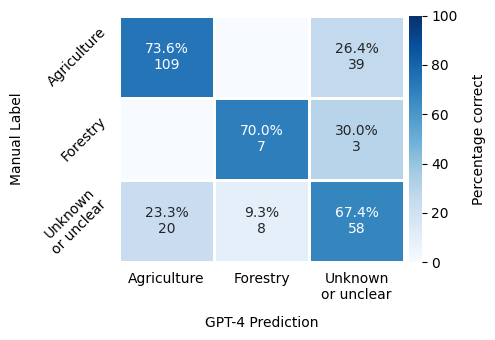



                    precision    recall  f1-score   support

       Agriculture      0.845     0.736     0.787       148
          Forestry      0.467     0.700     0.560        10
Unknown
or unclear      0.580     0.674     0.624        86

          accuracy                          0.713       244
         macro avg      0.631     0.704     0.657       244
      weighted avg      0.736     0.713     0.720       244



In [185]:
plot_confusion_matrix(x['Associated With'], y['Associated With'], labels=labels, xlab='GPT-4 Prediction', ylab='Manual Label', train_test='test',
                      figsize=(5,3.5), xrot=0, yrot=45, filename='cm_industry')

In [186]:
# Comparison with Pest_Industry_Hallucinations.pdf: 

num_abstracts = 11
num_species = 20

print('Abstracts where mismatched pest type was likely to be hallucinated: \t0/11')
print('Corresponding to 0/20 species (%s)'%np.round(0/20,3))

print('\nAbstracts where mismatched pest type turned out to be correct: \t\t11/11')
print('Corresponding to 20/20 species (%s)'%np.round(20/20,3))

Abstracts where mismatched pest type was likely to be hallucinated: 	0/11
Corresponding to 0/20 species (0.0)

Abstracts where mismatched pest type turned out to be correct: 		11/11
Corresponding to 20/20 species (1.0)


In [187]:
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-32544437705')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-0242446679')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-77956400174')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-84857317215')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Forestry')&(x['EID']=='2-s2.0-0034551082')]='Forestry'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Forestry')&(x['EID']=='2-s2.0-0028560901')]='Forestry'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-0033674416')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-84937421125')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-85044712561')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-84946493859')]='Agriculture'
x[(x['Associated With']=='Unknown\nor unclear')&(y['Associated With']=='Agriculture')&(x['EID']=='2-s2.0-0035466062')]='Agriculture'

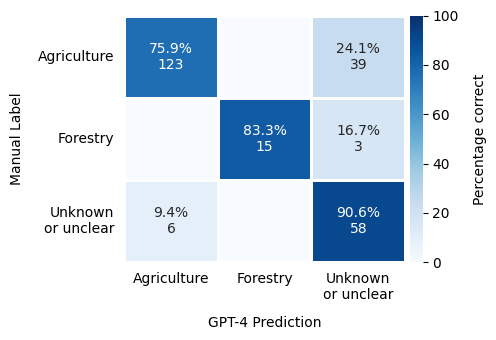



                    precision    recall  f1-score   support

       Agriculture      0.953     0.759     0.845       162
          Forestry      1.000     0.833     0.909        18
Unknown
or unclear      0.580     0.906     0.707        64

          accuracy                          0.803       244
         macro avg      0.844     0.833     0.821       244
      weighted avg      0.859     0.803     0.814       244



In [188]:
plot_confusion_matrix(x['Associated With'], y['Associated With'], labels=labels, xlab='GPT-4 Prediction', ylab='Manual Label', train_test='test',
                      figsize=(5,3.5), xrot=0, filename='cm_industry')

# Locations

## Training set 

In [11]:
print('{:5s} | {:20s} | {:20s} | {:20s}'.format('Index','EID','Manual label','Prediction')) 
for _,(i,j) in enumerate(zip(df1_train_['Location'], df2_train_['Location'])): 
    if i!=j:
        print('{:5} | {:20s} | {:20s} | {:20s}'.format(df1_train_.index[_],df1_train_['EID'].iloc[_],i,j))

Index | EID                  | Manual label         | Prediction          
    0 | 2-s2.0-0000101789    | Northern New Zealand | New Zealand         
    1 | 2-s2.0-0000101789    | Northern New Zealand | New Zealand         
   22 | 2-s2.0-0008215387    | Mundubbera, Nambour, and Brisbane in south-east Queensland | Mundubbera, Queensland
   23 | 2-s2.0-0008215387    | Mundubbera, Nambour, and Brisbane in south-east Queensland | Mundubbera, Queensland
   24 | 2-s2.0-0008215387    | Mundubbera, Nambour, and Brisbane in south-east Queensland | Mundubbera, Queensland
   25 | 2-s2.0-0008215387    | Mundubbera, Nambour, and Brisbane in south-east Queensland | Mundubbera, Queensland
   26 | 2-s2.0-0008215387    | Mundubbera, Nambour, and Brisbane in south-east Queensland | Mundubbera, Queensland
   27 | 2-s2.0-0008215387    | Mundubbera, Nambour, and Brisbane in south-east Queensland | Mundubbera, Queensland
   28 | 2-s2.0-0008215387    | Mundubbera, Nambour, and Brisbane in south-east Queens

In [ ]:
# empty predictions: 73, 392,393,394,395,396, 617,618,619 (abstracts: 3)
# insufficient predictions: 377,378,379,380,381 (abstracts: 1) 

In [15]:
FP = [77,78,79,131,132,133] #checked manually
FN = [73,377,378,379,380,381,392,393,394,395,396,617,618,619] #checked manually
TN = df1_train_.index[(df1_train_['Location']==df2_train_['Location'])&(df1_train_['Location']=='')].tolist()
TN += [45,46,595,596,597,598,599] #checked manually
TP = df1_train_.index[(df1_train_['Location']==df2_train_['Location'])&(df1_train_['Location']!='')].tolist()
TP += list(set(df1_train_.index[(df1_train_['Location']!=df2_train_['Location'])].tolist())-set(FP)-set(FN)-set(TN))

print(len(FP), len(FN), len(TN), len(TP), len(FP)+len(FN)+len(TN)+len(TP))

6 14 138 473 631


In [65]:
a1 = pd.DataFrame(np.zeros(len(df1_train_)), columns = ['Location'], index=df1_train_.index, dtype='str')
a2 = pd.DataFrame(np.zeros(len(df1_train_)), columns = ['Location'], index=df1_train_.index, dtype='str')

for i in FP: 
    a1.loc[i] = 'No Location'
    a2.loc[i] = 'Location'
for i in FN: 
    a1.loc[i] = 'Location'
    a2.loc[i] = 'No Location'
for i in TP: 
    a1.loc[i] = 'Location'
    a2.loc[i] = 'Location'
for i in TN:
    a1.loc[i] = 'No Location'
    a2.loc[i] = 'No Location'

np.unique(a1), np.unique(a2)

(array(['Location', 'No Location'], dtype=object),
 array(['Location', 'No Location'], dtype=object))

In [69]:
a1['EID'] = df1_train_['EID']
a2['EID'] = df2_train_['EID']

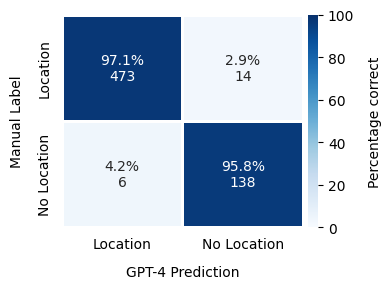



              precision    recall  f1-score   support

    Location      0.987     0.971     0.979       487
 No Location      0.908     0.958     0.932       144

    accuracy                          0.968       631
   macro avg      0.948     0.965     0.956       631
weighted avg      0.969     0.968     0.969       631



In [70]:
plot_confusion_matrix(a1['Location'], a2['Location'], labels=['Location','No Location'], xlab='GPT-4 Prediction', ylab='Manual Label', train_test='train',
                      figsize=(4,3), xrot=0, yrot=90, filename='cm_locations')

In [71]:
# scores per abstract 

eids = np.unique(df1_train_['EID'])

scores_per_abstract(a1, a2, eids, header='Location', labels=['Location','No Location'])

Label: Location (num abstracts: 67)
precision:	97.1 +/- 16.9
recall:		96.3 +/- 16.6
f1:		98.3 +/- 9.4


Label: No Location (num abstracts: 34)
precision:	88.9 +/- 31.4
recall:		94.1 +/- 23.5
f1:		100.0 +/- 0.0




## Test set 

In [72]:
print('{:5s} | {:20s} | {:20s} | {:20s}'.format('Index','EID','Manual label','Prediction')) 
for _,(i,j) in enumerate(zip(df1_test_['Location'], df2_test_['Location'])): 
    if i!=j:
        print('{:5} | {:20s} | {:20s} | {:20s}'.format(df1_test_.index[_],df1_test_['EID'].iloc[_],i,j))

Index | EID                  | Manual label         | Prediction          
   12 | 2-s2.0-84994091578   |                      | China               
   26 | 2-s2.0-0028973895    | Souss Valley of Morocco | Souss Valley, Morocco
   27 | 2-s2.0-0028973895    | Souss Valley of Morocco | Souss Valley, Morocco
   28 | 2-s2.0-0028973895    | Souss Valley of Morocco | Souss Valley, Morocco
   33 | 2-s2.0-84903955217   | Embrapa Algodão in Campina Grande, Paraíba | Campina Grande, Paraíba
   42 | 2-s2.0-77956400174   | northwestern Colorado, northeastern Utah, and southwestern Wyoming | Northwestern Colorado, Northeastern Utah, Southwestern Wyoming
   48 | 2-s2.0-79960479277   | La Tupia field station (Candelaria, Valle), Colombia | Colombia, La Tupia field station
   49 | 2-s2.0-79960479277   | La Tupia field station (Candelaria, Valle), Colombia | Colombia, La Tupia field station
   50 | 2-s2.0-79960479277   | La Tupia field station (Candelaria, Valle), Colombia | Colombia, La Tupia field s

In [73]:
FP = [12, 72, 73, 110, 161, 239, 240] #checked manually
FN = [75, 76, 77, 78, 79, 107, 206] #checked manually
TN = df1_test_.index[(df1_test_['Location']==df2_test_['Location'])&(df1_test_['Location']=='')].tolist()
TP = df1_test_.index[(df1_test_['Location']==df2_test_['Location'])&(df1_test_['Location']!='')].tolist()
TP += list(set(df1_test_.index[(df1_test_['Location']!=df2_test_['Location'])].tolist())-set(FP)-set(FN))

len(FP), len(FN), len(TN), len(TP), len(FP)+len(FN)+len(TN)+len(TP)

(7, 7, 88, 142, 244)

In [79]:
a1 = pd.DataFrame(np.zeros(len(df1_test_)), columns=['Location'], index=df1_test_.index,dtype='str')
a2 = pd.DataFrame(np.zeros(len(df1_test_)), columns=['Location'], index=df1_test_.index,dtype='str')

for i in FP: 
    a1.loc[i] = 'No Location'
    a2.loc[i] = 'Location'
for i in FN: 
    a1.loc[i] = 'Location'
    a2.loc[i] = 'No Location'
for i in TP: 
    a1.loc[i] = 'Location'
    a2.loc[i] = 'Location'
for i in TN:
    a1.loc[i] = 'No Location'
    a2.loc[i] = 'No Location'

np.unique(a1), np.unique(a2)

(array(['Location', 'No Location'], dtype=object),
 array(['Location', 'No Location'], dtype=object))

In [83]:
a1['EID'] = df1_test_['EID']
a2['EID'] = df2_test_['EID']

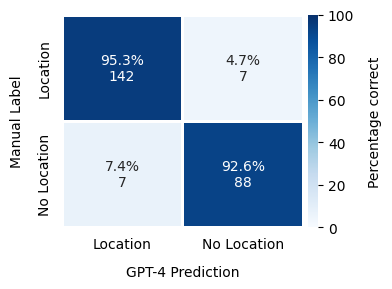



              precision    recall  f1-score   support

    Location      0.953     0.953     0.953       149
 No Location      0.926     0.926     0.926        95

    accuracy                          0.943       244
   macro avg      0.940     0.940     0.940       244
weighted avg      0.943     0.943     0.943       244



In [75]:
plot_confusion_matrix(a1['Location'], a2['Location'], labels=['Location','No Location'], xlab='GPT-4 Prediction', ylab='Manual Label', train_test='test',
                      figsize=(4,3), xrot=0, yrot=90, filename='cm_locations')

In [84]:
# scores per abstract 

eids = np.unique(df1_test_['EID'])

scores_per_abstract(a1, a2, eids, header='Location', labels=['Location','No Location'])

Label: Location (num abstracts: 54)
precision:	92.1 +/- 26.1
recall:		96.3 +/- 17.5
f1:		97.9 +/- 10.7


Label: No Location (num abstracts: 46)
precision:	93.2 +/- 25.2
recall:		89.1 +/- 31.1
f1:		100.0 +/- 0.0




## Training set

In [8]:
y_true_train = np.array(df1_train_['Category'])
y_true_train = np.array([str(x) for x in y_true_train])

y_pred_train = np.array(df2_train_['Category'])
y_pred_train = np.array([str(x) for x in y_pred_train])

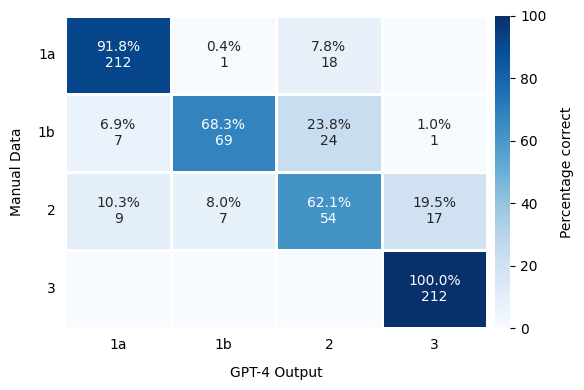



              precision    recall  f1-score   support

          1a      0.930     0.918     0.924       231
          1b      0.896     0.683     0.775       101
           2      0.562     0.621     0.590        87
           3      0.922     1.000     0.959       212

    accuracy                          0.867       631
   macro avg      0.828     0.805     0.812       631
weighted avg      0.871     0.867     0.866       631



In [9]:
plot_confusion_matrix(y_true_train, y_pred_train, labels=['1a','1b','2','3'],xlab='GPT-4 Output',ylab='Manual Data',train_test='train',
                      figsize=(6,4),xrot=0,filename='cm_classifications')

In [15]:
# scores per abstract: 

arr1 = df1_train_[['Category','EID']].copy()
arr2 = df2_train_[['Category','EID']].copy()

eids = np.unique(df1_train_['EID'])

scores_per_abstract(arr1, arr2, eids, header='Category', labels=['1a','1b','2','3'])

Label: 1a (num abstracts: 54)
precision:	89.7 +/- 30.5
recall:		92.3 +/- 23.5
f1:		97.0 +/- 12.2
Label: 1b (num abstracts: 16)
precision:	68.8 +/- 46.4
recall:		62.1 +/- 44.7
f1:		93.6 +/- 12.7
Label: 2 (num abstracts: 22)
precision:	59.7 +/- 48.6
recall:		72.3 +/- 42.6
f1:		90.7 +/- 22.5
Label: 3 (num abstracts: 84)
precision:	97.5 +/- 13.5
recall:		100.0 +/- 0.0
f1:		99.1 +/- 5.9


## Test set 

In [17]:
y_true_test = np.array(df1_test_['Category'])
y_true_test = np.array([str(x) for x in y_true_test])

y_pred_test = np.array(df2_test_['Category'])
y_pred_test = np.array([str(x) for x in y_pred_test])

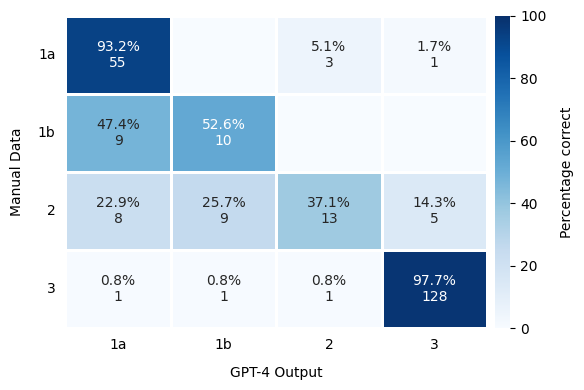



              precision    recall  f1-score   support

          1a      0.753     0.932     0.833        59
          1b      0.500     0.526     0.513        19
           2      0.765     0.371     0.500        35
           3      0.955     0.977     0.966       131

    accuracy                          0.844       244
   macro avg      0.743     0.702     0.703       244
weighted avg      0.844     0.844     0.832       244



In [18]:
plot_confusion_matrix(y_true_test, y_pred_test, labels=['1a','1b','2','3'],xlab='GPT-4 Output',ylab='Manual Data',train_test='test',
                      figsize=(6,4),xrot=0,filename='cm_classifications')

In [19]:
# scores per abstract: 

arr1 = df1_test_[['Category','EID']].copy()
arr2 = df2_test_[['Category','EID']].copy()

eids = np.unique(df1_test_['EID'])

scores_per_abstract(arr1, arr2, eids, header='Category', labels=['1a','1b','2','3'])

Label: 1a (num abstracts: 30)
precision:	78.3 +/- 40.7
recall:		93.1 +/- 20.6
f1:		95.4 +/- 13.8


Label: 1b (num abstracts: 9)
precision:	55.6 +/- 49.7
recall:		55.6 +/- 49.7
f1:		100.0 +/- 0.0


Label: 2 (num abstracts: 12)
precision:	56.2 +/- 46.4
recall:		34.7 +/- 46.4
f1:		79.0 +/- 28.3


Label: 3 (num abstracts: 92)
precision:	98.5 +/- 11.0
recall:		97.6 +/- 14.7
f1:		99.7 +/- 2.3




# Abstract Lengths

In [36]:
df_raw_train = pd.read_excel("data-sets/training_set_raw_output.xlsx",
                  true_values='Yes',
                  false_values='No',
                  sheet_name=0)

df_train = pd.read_excel("data-sets/training_set.xlsx",
                  true_values='Yes',
                  false_values='No',
                  sheet_name=0)

In [38]:
# raw GPT-4 output: 

num_entries = pd.DataFrame(columns=['EID','n'])

for i, eid in enumerate(np.unique(df_raw_train['EID'])):
    subset = df_raw_train[df_raw_train['EID']==eid]
    num_entries.loc[i] = [eid,len(subset)]

num_entries = num_entries.sort_values('n')

num_entries[-5:]

# 2-s2.0-80053068062 -> 58 rows (longest)
# 2-s2.0-19944366420 -> 25 rows (2nd longest)

,EID,n
48,2-s2.0-33845901783,18
73,2-s2.0-84881063573,21
63,2-s2.0-77957191872,22
43,2-s2.0-19944366420,25
68,2-s2.0-80053068062,58


In [37]:
# manual labels: 

num_entries = pd.DataFrame(columns=['EID','n'])

for i, eid in enumerate(np.unique(df_train['EID'])):
    subset = df_train[df_train['EID']==eid]
    num_entries.loc[i] = [eid,len(subset)]

num_entries = num_entries.sort_values('n')

num_entries[-5:]

# 2-s2.0-80053068062 -> 37 rows (longest)
# 2-s2.0-19944366420 -> 20 rows (4th longest) 

,EID,n
48,2-s2.0-33845901783,18
43,2-s2.0-19944366420,20
73,2-s2.0-84881063573,21
63,2-s2.0-77957191872,22
68,2-s2.0-80053068062,37
